In [ ]:
from multiprocessing import freeze_support
freeze_support()

In [ ]:
import matplotlib.pyplot as P

def show(*xs):
    P.figure(figsize=(8,8))
    for i, x in enumerate(xs, 1):
        P.subplot(len(xs), len(xs), i)
        P.imshow(x, cmap='gray')
        P.xticks([])
        P.yticks([])
    P.tight_layout()
    P.show()

In [ ]:
from interface import load_model, predict

In [ ]:
model = load_model('D:/ACDC_LUNG_try2/checkpoints/19-02-22/model_inception_2277_acc=0.967.pth')

In [ ]:
x, y = predict(model, 'D:/ACDC_LUNG_HISTOPATHOLOGY/data/slides/82.tif')

In [ ]:
x.shape

In [ ]:
# p = 'D:/ACDC_LUNG_try2/prediction.png'
# x = cv2.imread(p)[..., 0]

In [ ]:
from ipywidgets import interact

@interact(thres=(0,255))
def show_(thres):
    show(x > thres)

In [ ]:
x_blur=cv2.GaussianBlur(x, (5,5), 0)

In [ ]:
print('acc')
(x_ == y).sum() / x_.size

In [ ]:
x_ = x_.astype(bool).astype('float32')
y_ = y.astype(bool).astype('float32')

print('precision', (x_ * y_).sum() / y_.sum())
print('recall', (x_ * y_).sum() / x_.sum())
print('dice', 2 * (x_ * y_).sum() / (x_.sum() + y_.sum()))

In [6]:
import sys
# https://github.com/computationalpathologygroup/ASAP/releases
# Automated Slide Analysis Platform (ASAP) is an open source platform
if 'D:\\ACDC_LUNG_HISTOPATHOLOGY\\ASAP 1.9\\bin' not in sys.path:
    sys.path.append('D:\\ACDC_LUNG_HISTOPATHOLOGY\\ASAP 1.9\\bin')
import multiresolutionimageinterface as mir

_READER=mir.MultiResolutionImageReader()

In [ ]:
def get_thumbnail(slide_path, zoom=4):
    slide = _READER.open(slide_path)
    slide_shape = slide.getDimensions()
    thumbnail = slide.getUCharPatch(
        0, 0, slide_shape[0] // 2**zoom, slide_shape[1] // 2**zoom, zoom
    )
    slide.close()
    return (thumbnail, slide_shape)

In [ ]:
slide=get_thumbnail('D:/ACDC_LUNG_HISTOPATHOLOGY/data/slides/82.tif')[0]

In [ ]:
# x_new = x.copy()
# x_new[x_new < 250] = 0
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
# dilation = cv2.dilate(x_new, kernel, iterations = 1)
# x_median=cv2.medianBlur(dilation, 7)
# x_median = cv2.erode(x_median, kernel, iterations = 1)
x_new = x.copy()
x_new[x_new < 250] = 0
x_median=cv2.medianBlur(x_new, 7)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
opening = cv2.morphologyEx(x_median, cv2.MORPH_OPEN, kernel)

x_blur=cv2.GaussianBlur(x_new, (3,3), 0)

dpi = 300
plt.figure(figsize=(20, 40), dpi=dpi)

plt.subplot(441)
plt.title('Original slide')
plt.imshow(slide)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.subplot(442)
plt.title('Target')
plt.imshow(y)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.subplot(443)
plt.title('Original Predict')
plt.imshow(x_new)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.subplot(444)
plt.title('Some Morphological Transformations')
plt.imshow(opening)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

# plt.savefig('example82.png', bbox_inches='tight', dpi=dpi)

In [ ]:
np.unique(y)

In [ ]:
import torch

In [ ]:
jet = cv2.applyColorMap(x_blur, cv2.COLORMAP_PARULA)
plt.imshow(jet)

In [ ]:
z = (torch.from_numpy(img).float() +
     (torch.from_numpy(jet).float() - torch.from_numpy(img).float()) * 
     torch.from_numpy(y[..., None]).expand(img.shape).float()
    ).clamp(0,255).byte().numpy()
plt.imshow(z)

In [ ]:
x_new = x.copy()
x_new[x_new < 250] = 0
x_blur=cv2.GaussianBlur(x_new, (3,3), 0)

In [ ]:
f

In [ ]:
x_=cv2.medianBlur(x, 5)

In [ ]:
plt.imshow(x_)

In [ ]:
plt.imshow(x)

In [ ]:
d=dict(a=1, b=3, c=4)
c=dict(a=200, b=32, k=4)

In [7]:
import os
import gc
import random
import numpy as np
import xml.etree.ElementTree as ET
from collections import namedtuple, defaultdict
from shapely.geometry import Polygon, MultiPolygon, Point
from threading import get_ident, local

_PATHS = namedtuple(
    '_PATHS', ['slide_path', 'mask_path', 'tissue_xml', 'cancer_xml']
)
_COORDS = namedtuple('_COORDS', ['slide_path', 'coords'])
_MPOLYGON = namedtuple('_MPOLYGON', ['slide_path', 'mpolygon'])


# For train part
def get_all_paths(folder_with_data):
    return (
        _PATHS(
            folder_with_data + 'slides/' + name,
            folder_with_data + 'masks/' + name.replace('.', '_M.'),
            folder_with_data + 'annotations/' + name.replace('.tif', '_G.xml'),
            folder_with_data + 'annotations/' + name.replace('.tif', '.xml')
        ) for name in os.listdir(folder_with_data + 'slides/')
    )


# def get_coords(_list, cancer=True):
#     for el in _list:
#         if cancer:
#             xml_file = el.cancer_xml
#         else:
#             xml_file = el.tissue_xml
#         for ann in ET.parse(xml_file).getroot().find('Annotations'):
#             xy = [
#                 (int(float(coord.attrib['X'])), int(float(coord.attrib['Y'])))
#                 for coord in ann.find('Coordinates').findall('Coordinate')
#             ]
#             yield _COORDS(el.slide_path, xy)

def get_coords(_list, cancer=True):
    if cancer:
        xml_file = _list.cancer_xml
    else:
        xml_file = _list.tissue_xml
    for ann in ET.parse(xml_file).getroot().find('Annotations'):
        xy = [
            (int(float(coord.attrib['X'])), int(float(coord.attrib['Y'])))
            for coord in ann.find('Coordinates').findall('Coordinate')
        ]
        yield _COORDS(_list.slide_path, xy)

def to_dict(_list):
    d = defaultdict(list)
    for _el in _list:
        d[_el.slide_path].append(_el.coords)
    return d


def to_multi(d):
    new_d = defaultdict()
    for slide_path, coords in d.items():
        new_d[slide_path]=MultiPolygon([[points, []] for points in coords]).buffer(5)
    return new_d

def subtraction(tissue, cancer):
    for k in (set(tissue) & set(cancer)):
        tissue_mpolygn=tissue[k]
        cancer_mpolygon=cancer[k]
        tissue[k]=tissue_mpolygn-cancer_mpolygon
    return(tissue, cancer)

_TLS = local()


def tls_prng():
    # pylint: disable=no-member
    try:
        return _TLS.prng
    except AttributeError:
        _TLS.prng = np.random.RandomState(
            (get_ident() + np.random.get_state()[1][0]) % 2**32
        )
        return _TLS.prng


def get_random_point(polygon, count=1):
    prng = tls_prng()

    if not polygon.area:
        return

    minx, miny, maxx, maxy = polygon.bounds
    for _ in range(count):
        while True:
            p = Point(prng.uniform(minx, maxx), prng.uniform(miny, maxy))
            if polygon.contains(p):
                yield (int(p.coords[0][0]), int(p.coords[0][1]))
                break

In [2]:
all_paths=list(get_all_paths('D:/ACDC_LUNG_HISTOPATHOLOGY/data/'))
random.shuffle(all_paths)
train, valid = all_paths[:int(len(all_paths)*0.9)], all_paths[int(len(all_paths)*0.9):]

In [4]:
# t_cancer=to_multi(to_dict(list(get_coords(train))))
# v_cancer=to_multi(to_dict(list(get_coords(valid))))
# t_tissue=to_multi(to_dict(list(get_coords(train, cancer=False))))
# v_tissue=to_multi(to_dict(list(get_coords(valid, cancer=False))))

In [ ]:
# t_tissue, t_cancer = subtraction(t_tissue, t_cancer)
# v_tissue, v_cancer = subtraction(v_tissue, v_cancer)

In [ ]:
xy=list(get_random_point(t_tissue['D:/ACDC_LUNG_HISTOPATHOLOGY/data/slides/10.tif']))[0]

In [ ]:
sld=_READER.open('D:/ACDC_LUNG_HISTOPATHOLOGY/data/slides/32.tif')
msk=_READER.open('D:/ACDC_LUNG_HISTOPATHOLOGY/data/masks/32_M.tif')

In [ ]:
xy=list(get_random_point(t_tissue['D:/ACDC_LUNG_HISTOPATHOLOGY/data/slides/32.tif']))[0]
sld_patch=sld.getUCharPatch(xy[0], xy[1], 512, 512, 8)
msk_patch=msk.getUCharPatch(xy[0], xy[1], 512, 512, 8)

In [95]:
patch_size=(512,512)
for i in range(1):
    rnd_info=random.choice(all_paths)
    tissue_polygon=list(to_multi(to_dict(list(get_coords(rnd_info, cancer=False)))).values())[0]
    xy=list(get_random_point(tissue_polygon))[0]
    sld=_READER.open(rnd_info.slide_path)
    msk=_READER.open(rnd_info.mask_path)
    sld_patch=sld.getUCharPatch(xy[0], xy[1], patch_size[0], patch_size[1], 3)
    msk_patch=msk.getUCharPatch(xy[0], xy[1], patch_size[0], patch_size[1], 3)[:,:,0]
#     sld.close()
#     msk.close()
    gc.collect()

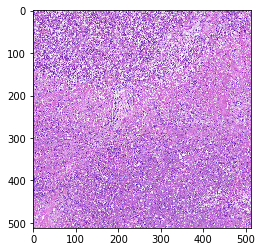

In [96]:
plt.imshow(sld_patch)

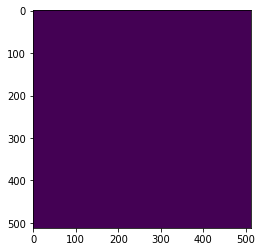

In [97]:
plt.imshow(msk_patch)

In [15]:
sld.getNumberOfLevels()

8

In [10]:
import matplotlib.pyplot as plt